# 🎸 Rolling Stones Spotify Music Analysis

This notebook explores the Spotify track data of *The Rolling Stones*, focusing on data cleaning, feature analysis, popularity correlation, and unsupervised learning using PCA and KMeans clustering to profile the music across decades.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

sns.set(style="whitegrid")


### Step 1: Importing Libraries and Reading Dataset

We load the dataset containing Spotify audio features of Rolling Stones tracks.

In [2]:
data = pd.read_csv('rolling_stones_spotify.csv', index_col=0)
data.head()

name               album release_date  track_number  \
0   Concert Intro Music - Live  Licked Live In NYC   2022-06-10             1   
1   Street Fighting Man - Live  Licked Live In NYC   2022-06-10             2   
2           Start Me Up - Live  Licked Live In NYC   2022-06-10             3   
3  If You Can't Rock Me - Live  Licked Live In NYC   2022-06-10             4   
4            Don’t Stop - Live  Licked Live In NYC   2022-06-10             5   

                       id                                   uri  acousticness  \
0  2IEkywLJ4ykbhi1yRQvmsT  spotify:track:2IEkywLJ4ykbhi1yRQvmsT        0.0824   
1  6GVgVJBKkGJoRfarYRvGTU  spotify:track:6GVgVJBKkGJoRfarYRvGTU        0.4370   
2  1Lu761pZ0dBTGpzxaQoZNW  spotify:track:1Lu761pZ0dBTGpzxaQoZNW        0.4160   
3  1agTQzOTUnGNggyckEqiDH  spotify:track:1agTQzOTUnGNggyckEqiDH        0.5670   
4  7piGJR8YndQBQWVXv6KtQw  spotify:track:7piGJR8YndQBQWVXv6KtQw        0.4000   

   danceability  energy  instrumentalness  liveness  loudness  speechiness  \
0         0.463   0.993          0.996000     0.932   -12.913       0.1100   
1         0.326   0.965          0.233000     0.961    -4.803       0.0759   
2         0.386   0.969          0.400000     0.956    -4.936       0.1150   
3         0.369   0.985          0.000107     0.895    -5.535       0.1930   
4         0.303   0.969          0.055900     0.966    -5.098       0.0930   

     tempo  valence  popularity  duration_ms  
0  118.001   0.0302          33        48640  
1  131.455   0.3180          34       253173  
2  130.066   0.3130          34       263160  
3  132.994   0.1470          32       305880  
4  130.533   0.2060          32       305106

### Step 2: Basic Data Exploration

Checking dataset shape, missing values, data types, and duplicates.

In [3]:
data.info()
data.isnull().sum()
data.duplicated(['id']).sum()

<class 'pandas.core.frame.DataFrame'>
Index: 1610 entries, 0 to 1609
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1610 non-null   object 
 1   album             1610 non-null   object 
 2   release_date      1610 non-null   object 
 3   track_number      1610 non-null   int64  
 4   id                1610 non-null   object 
 5   uri               1610 non-null   object 
 6   acousticness      1610 non-null   float64
 7   danceability      1610 non-null   float64
 8   energy            1610 non-null   float64
 9   instrumentalness  1610 non-null   float64
 10  liveness          1610 non-null   float64
 11  loudness          1610 non-null   float64
 12  speechiness       1610 non-null   float64
 13  tempo             1610 non-null   float64
 14  valence           1610 non-null   float64
 15  popularity        1610 non-null   int64  
 16  duration_ms       1610 non-null   int64  
dtype

np.int64(0)

### Step 3: Data Cleaning

- Convert `release_date` to datetime format.
- Convert `track_number` to category.
- Drop `id` and `uri` columns.

In [5]:
data.release_date = pd.to_datetime(data.release_date)
data.track_number = data.track_number.astype('category')
new_data = data.drop(columns=['id', 'uri'])

### Step 4: Distribution and Outlier Detection

Visualizing boxplots of all numeric variables to identify outliers.

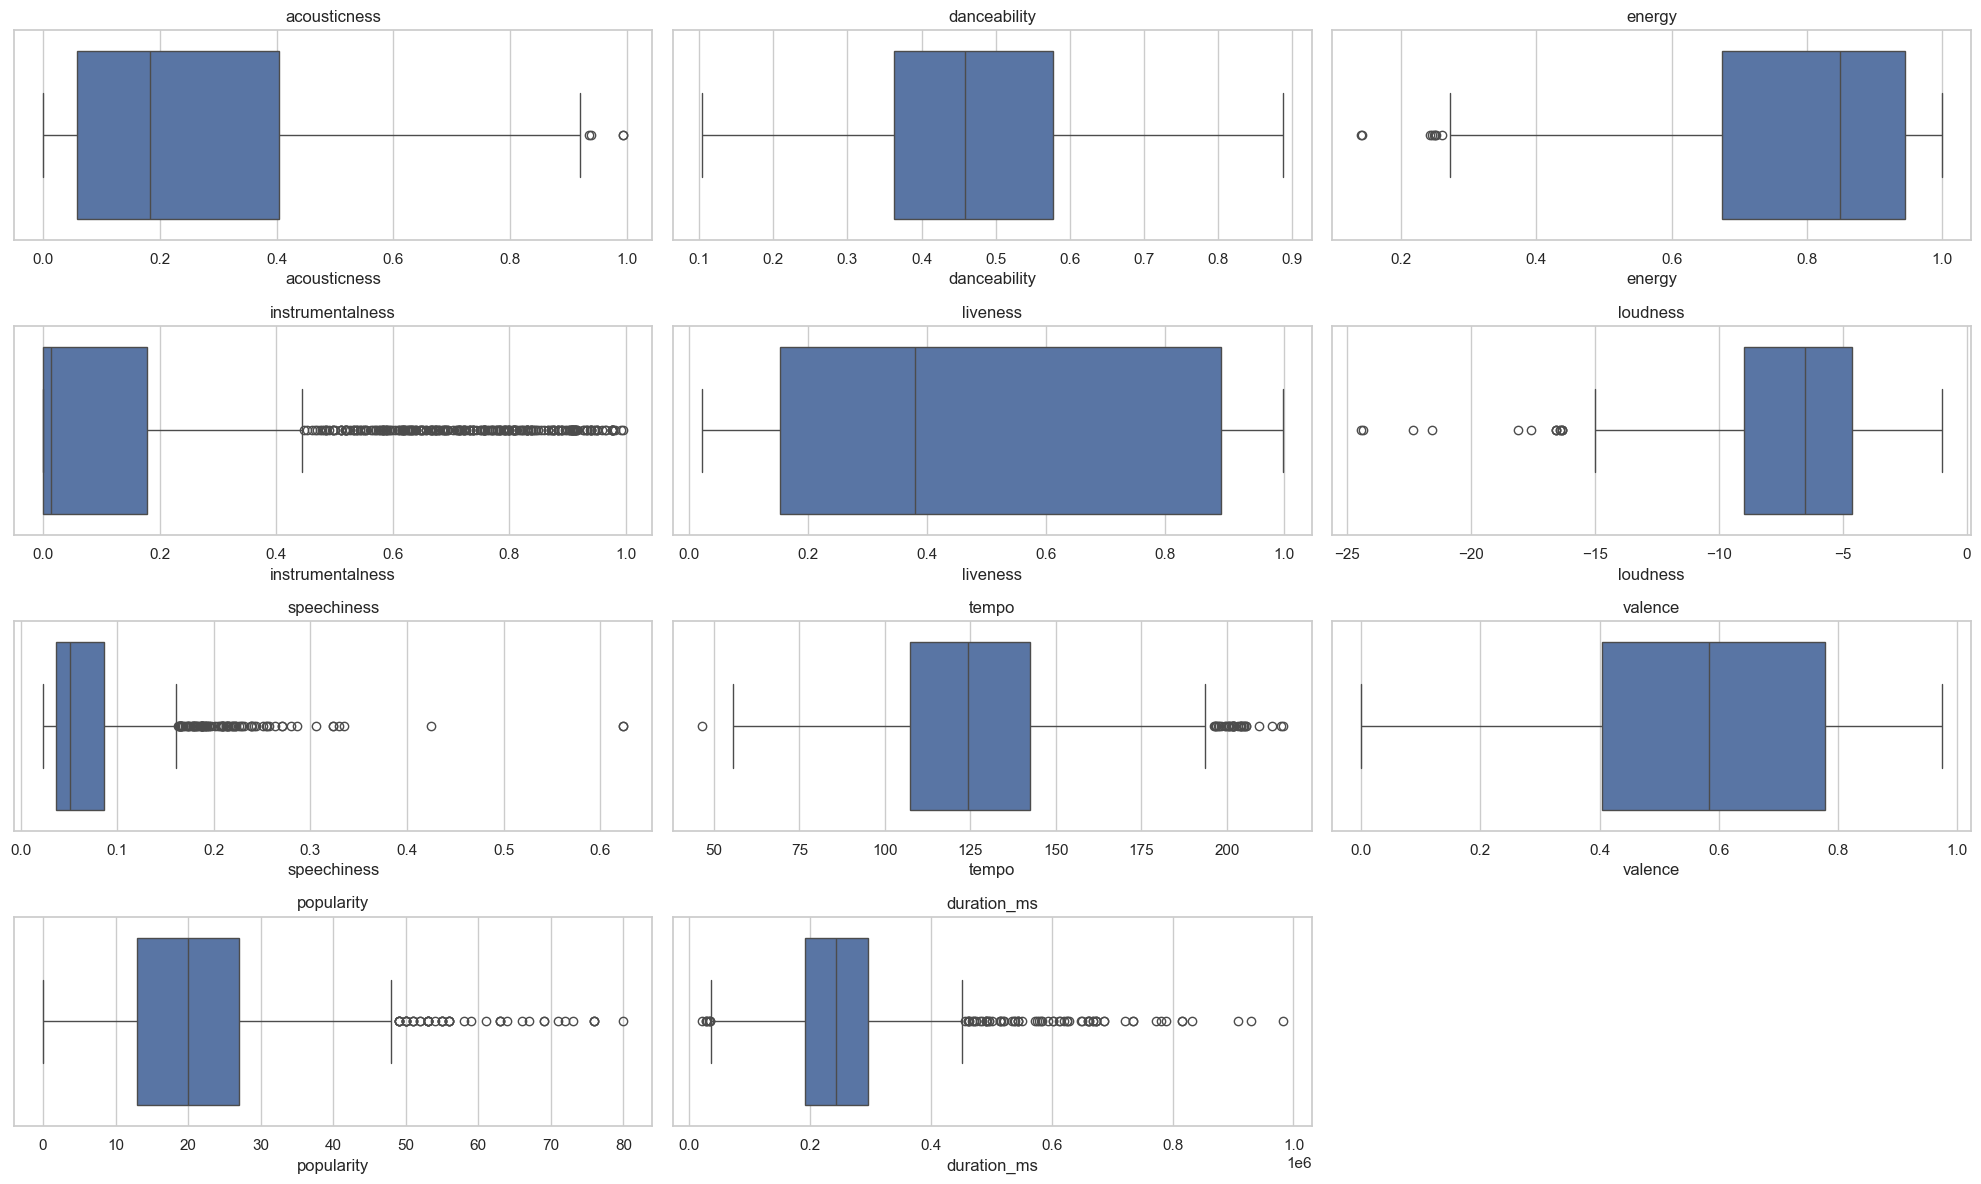

In [6]:
num_vars = new_data.select_dtypes(include=['float', 'int']).columns
f, ax = plt.subplots(4, 3, figsize=(20, 12))
k = 0
for i in range(4):
    for j in range(3):
        if k >= len(num_vars):
            ax[i, j].axis("off")
            break
        sns.boxplot(x=num_vars[k], data=new_data, ax=ax[i, j])
        ax[i, j].set_title(num_vars[k])
        k += 1
plt.tight_layout()


### Step 5: Outlier Treatment

We cap values beyond 1.5 IQR to remove extreme outliers while preserving data distribution.

In [21]:
def outlier_check(x):
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    return q1 - 1.5 * iqr, q3 + 1.5 * iqr

for var in num_vars:
    ll, ul = outlier_check(new_data[var])
    new_data[var] = np.clip(new_data[var], ll, ul)

### Step 6: Feature Engineering

Extracting `year` and `month` from the release date.


In [7]:
new_data['year'] = new_data.release_date.dt.year
new_data['mon'] = new_data.release_date.dt.month
new_data.drop(columns=['release_date'], inplace=True)

### Step 7: Top Tracks and Albums by Popularity

In [8]:
new_data.sort_values('popularity', ascending=False)[['name', 'album', 'popularity']].head(10)
new_data.groupby('album')['popularity'].mean().sort_values(ascending=False).head(10)


album
Sticky Fingers (Remastered)                                  53.300000
Some Girls                                                   48.100000
Tattoo You (2009 Re-Mastered)                                46.454545
Exile On Main Street (2010 Re-Mastered)                      44.166667
Beggars Banquet (50th Anniversary Edition)                   43.700000
Aftermath                                                    43.090909
Goats Head Soup (Remastered 2009)                            40.300000
Out Of Our Heads                                             39.583333
Black And Blue (Remastered 2009)                             38.500000
Let It Bleed (50th Anniversary Edition / Remastered 2019)    38.333333
Name: popularity, dtype: float64

### Step 8: Trend of Audio Features Over Years

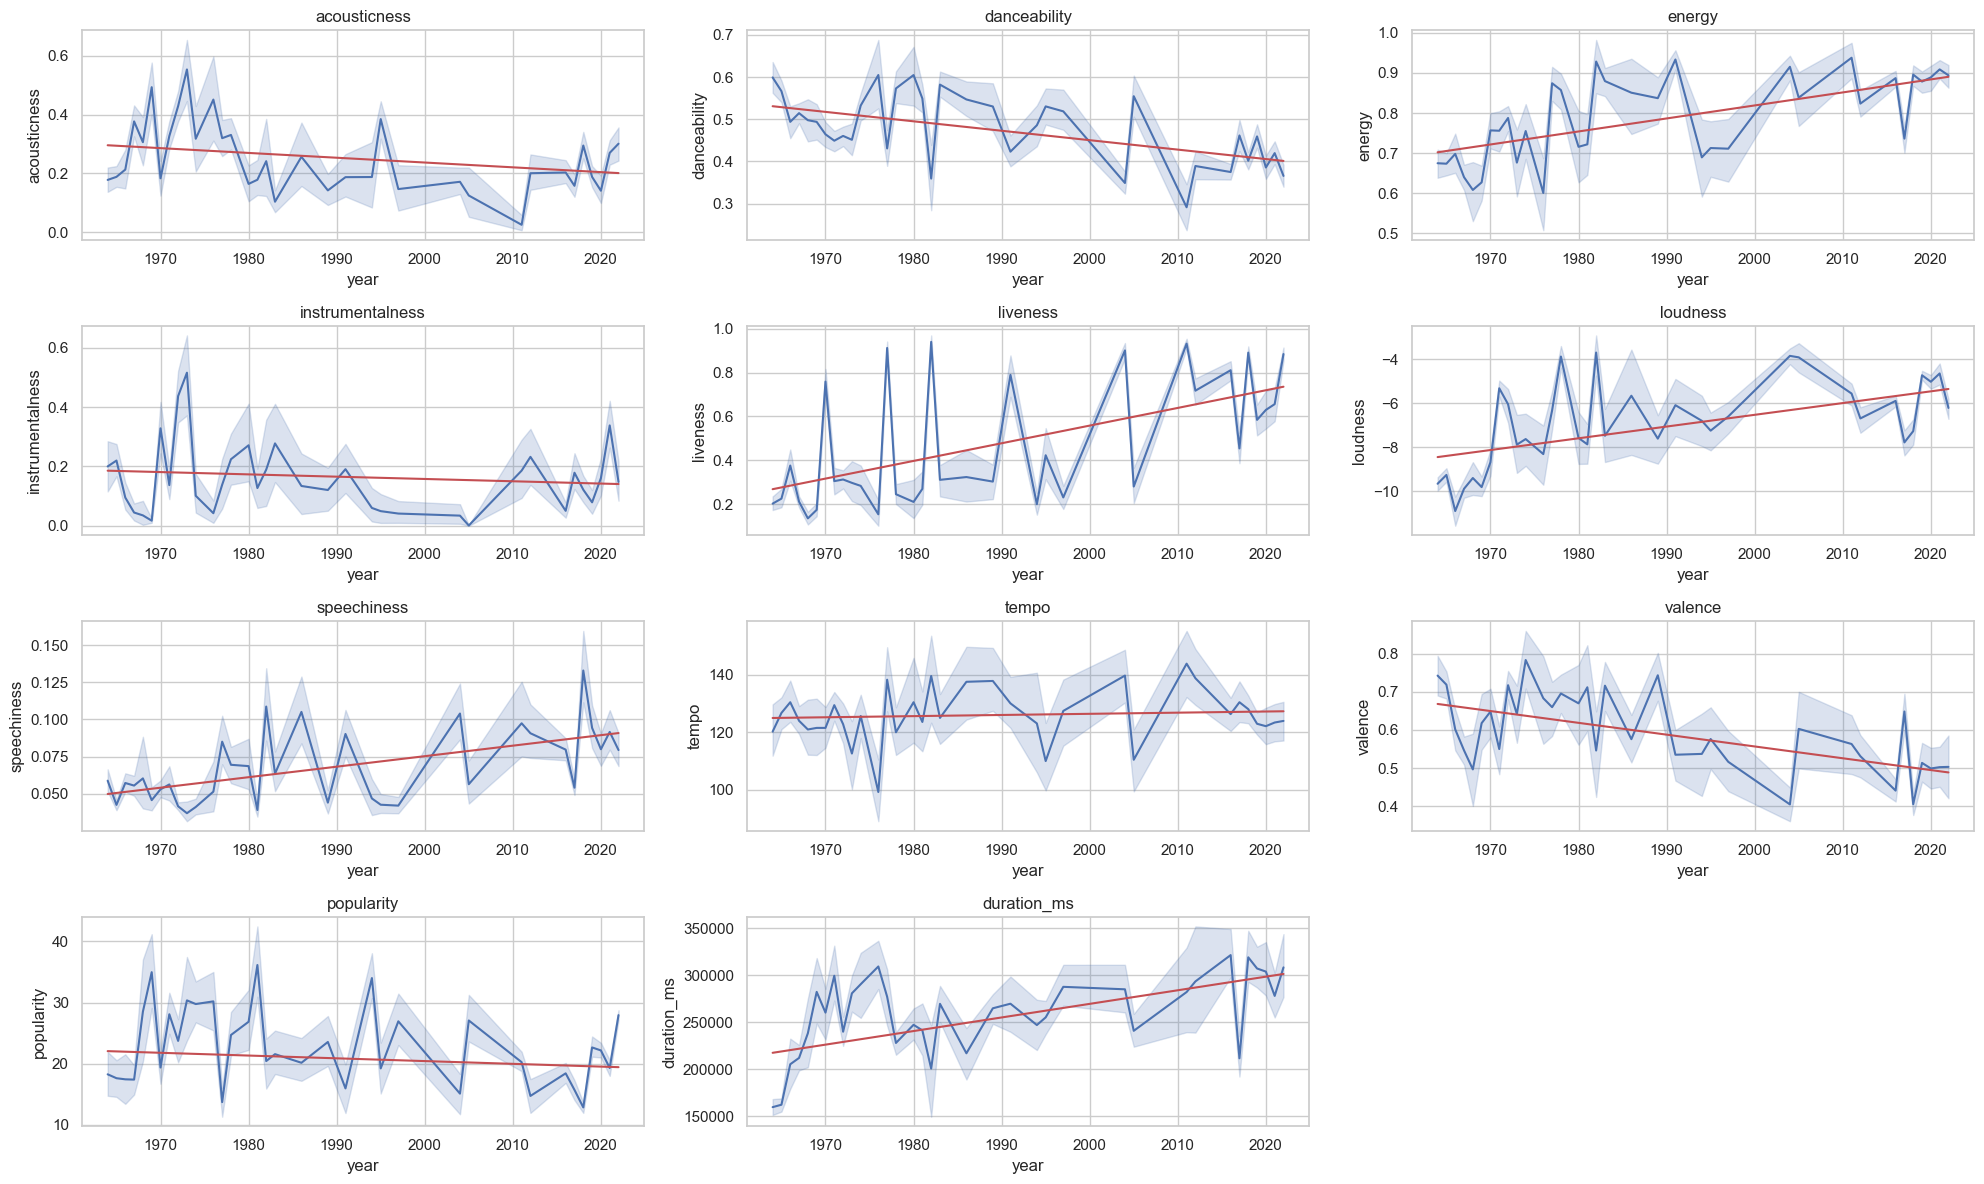

In [9]:
f, ax = plt.subplots(4, 3, figsize=(20, 12))
k = 0
for i in range(4):
    for j in range(3):
        if k >= len(num_vars):
            ax[i, j].axis("off")
            break
        sns.lineplot(x='year', y=num_vars[k], data=new_data, ax=ax[i, j])
        z = np.polyfit(new_data['year'], new_data[num_vars[k]], 1)
        ax[i, j].plot(new_data['year'], np.poly1d(z)(new_data['year']), "r")
        ax[i, j].set_title(num_vars[k])
        k += 1
plt.tight_layout()


### Step 9: Relationship Between Features and Popularity

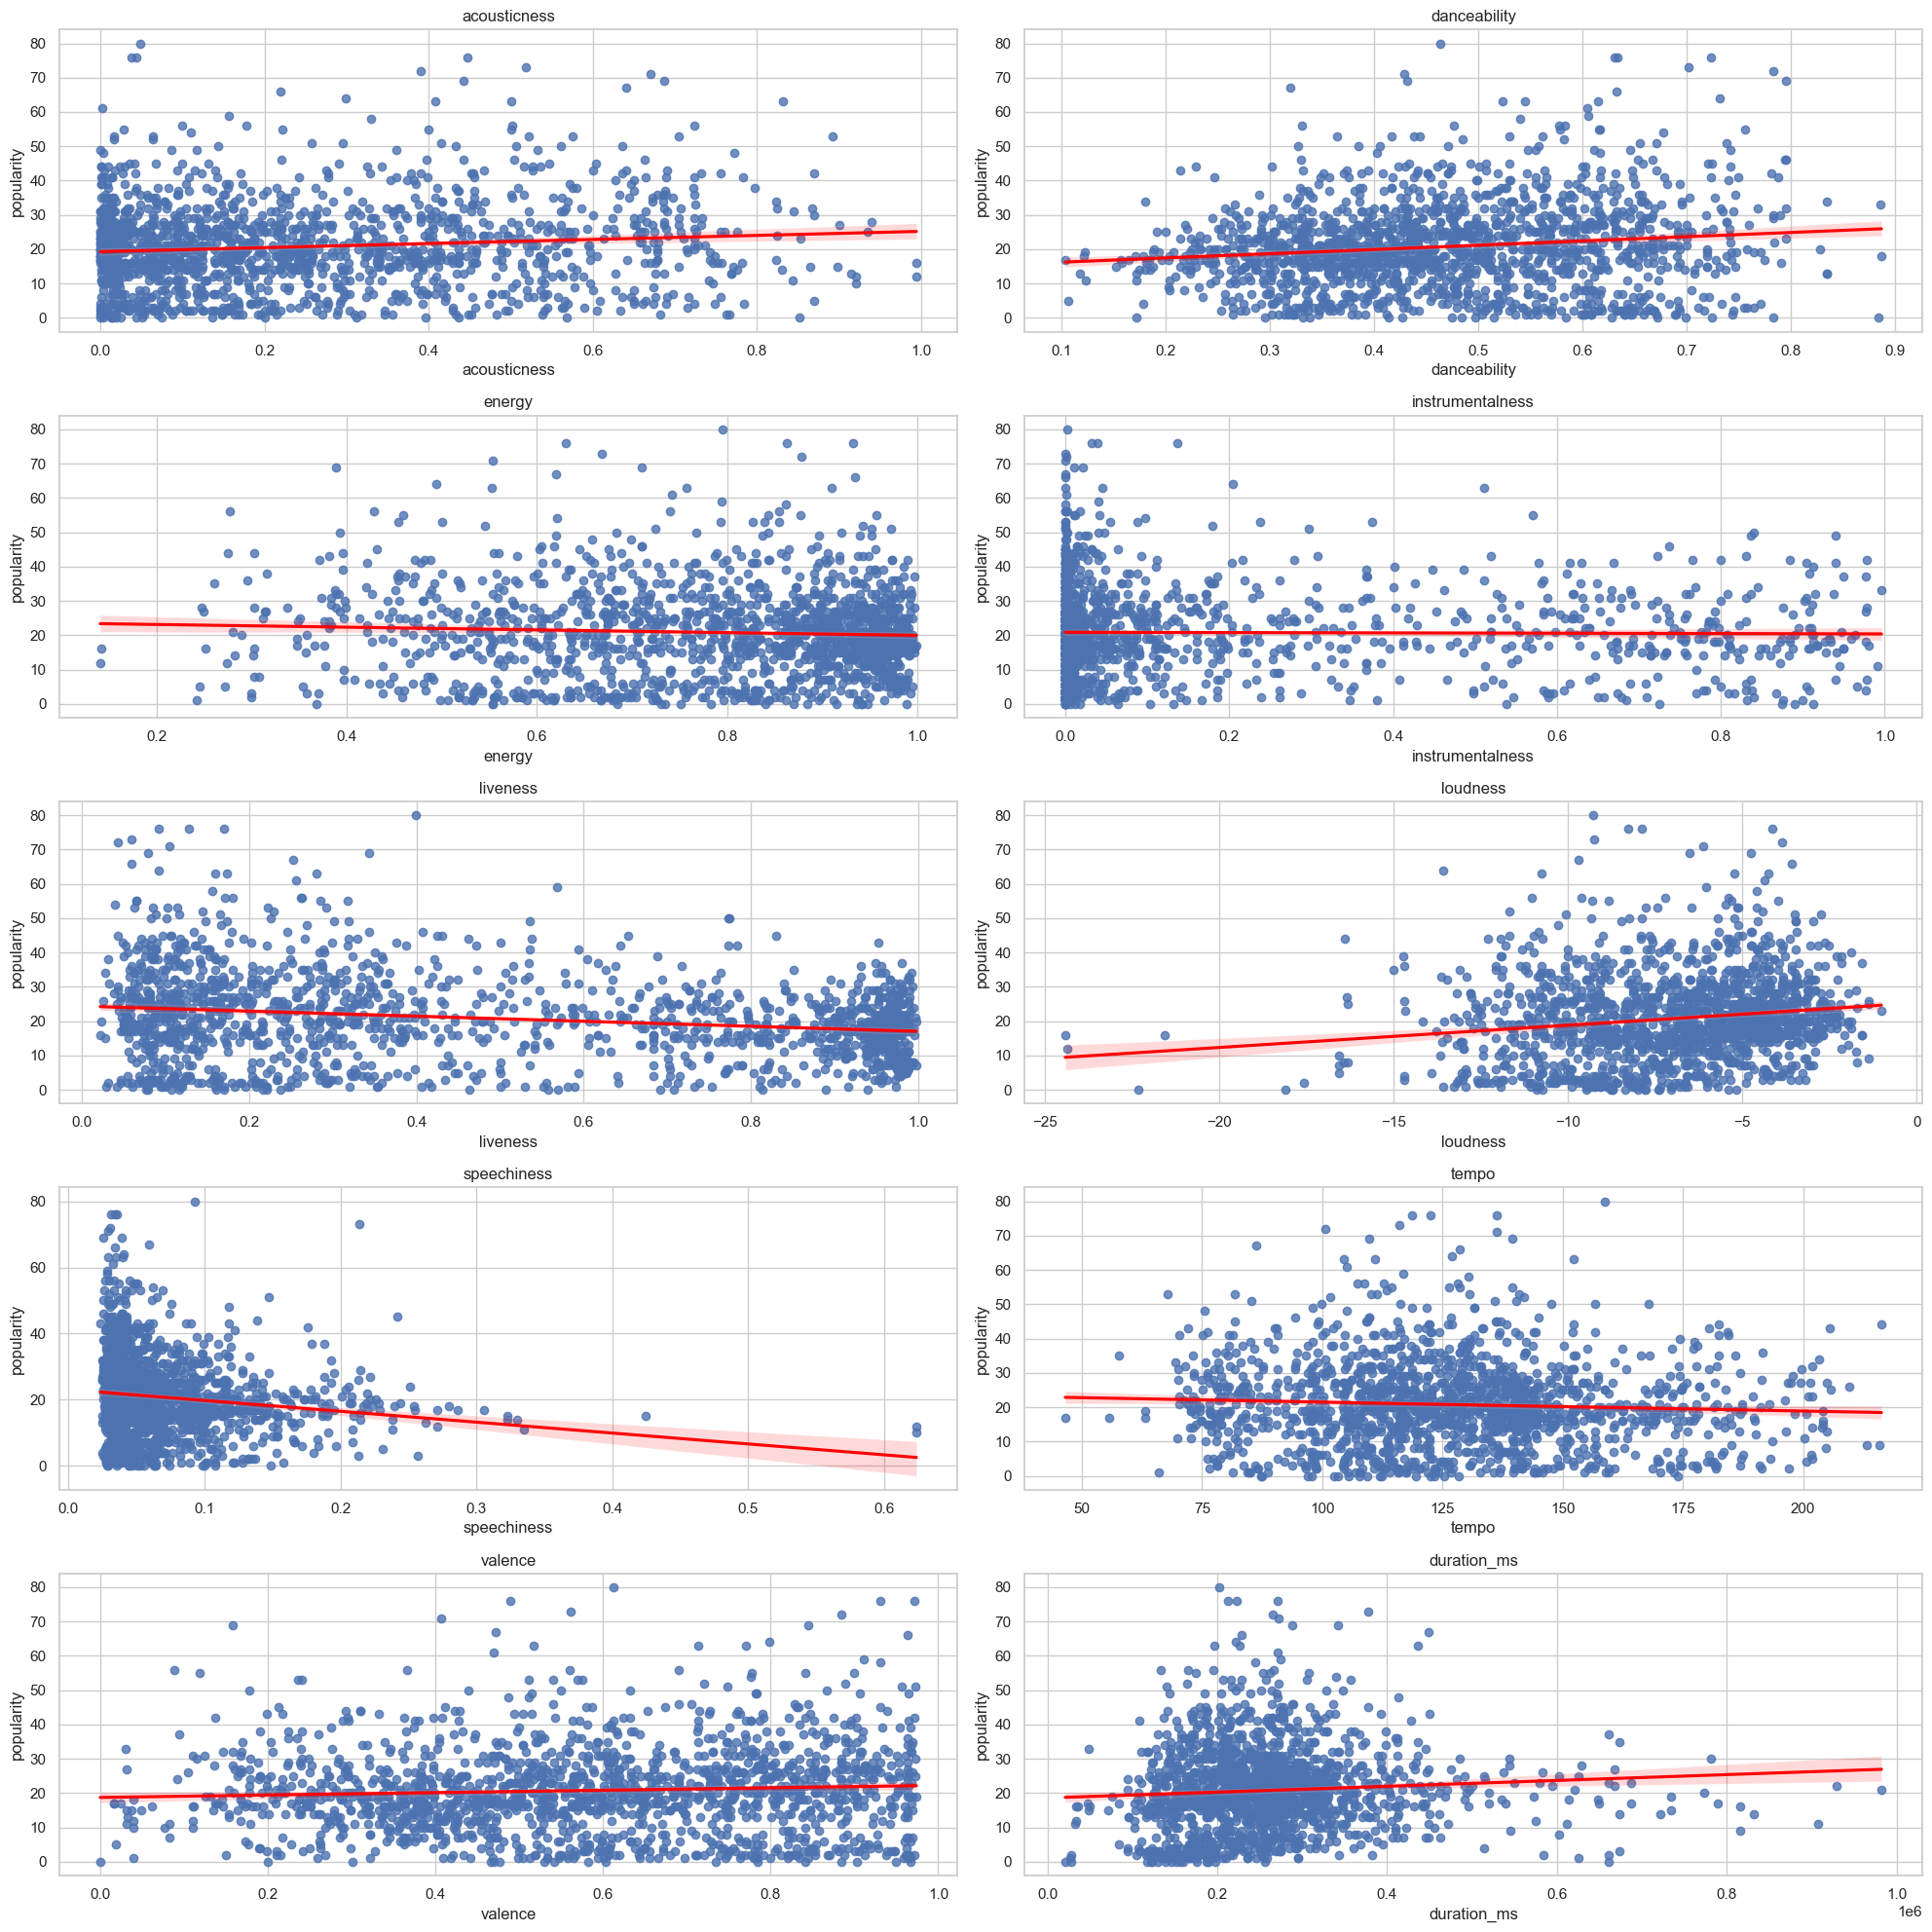

In [10]:
y = 'popularity'
vars = num_vars.drop('popularity')
f, ax = plt.subplots(5, 2, figsize=(20, 20))
k = 0
for i in range(5):
    for j in range(2):
        sns.regplot(x=vars[k], y=y, data=new_data, ax=ax[i, j], line_kws={'color': 'red'})
        ax[i, j].set_title(vars[k])
        k += 1
plt.tight_layout()


### Step 10: Feature Correlation with Popularity by Era

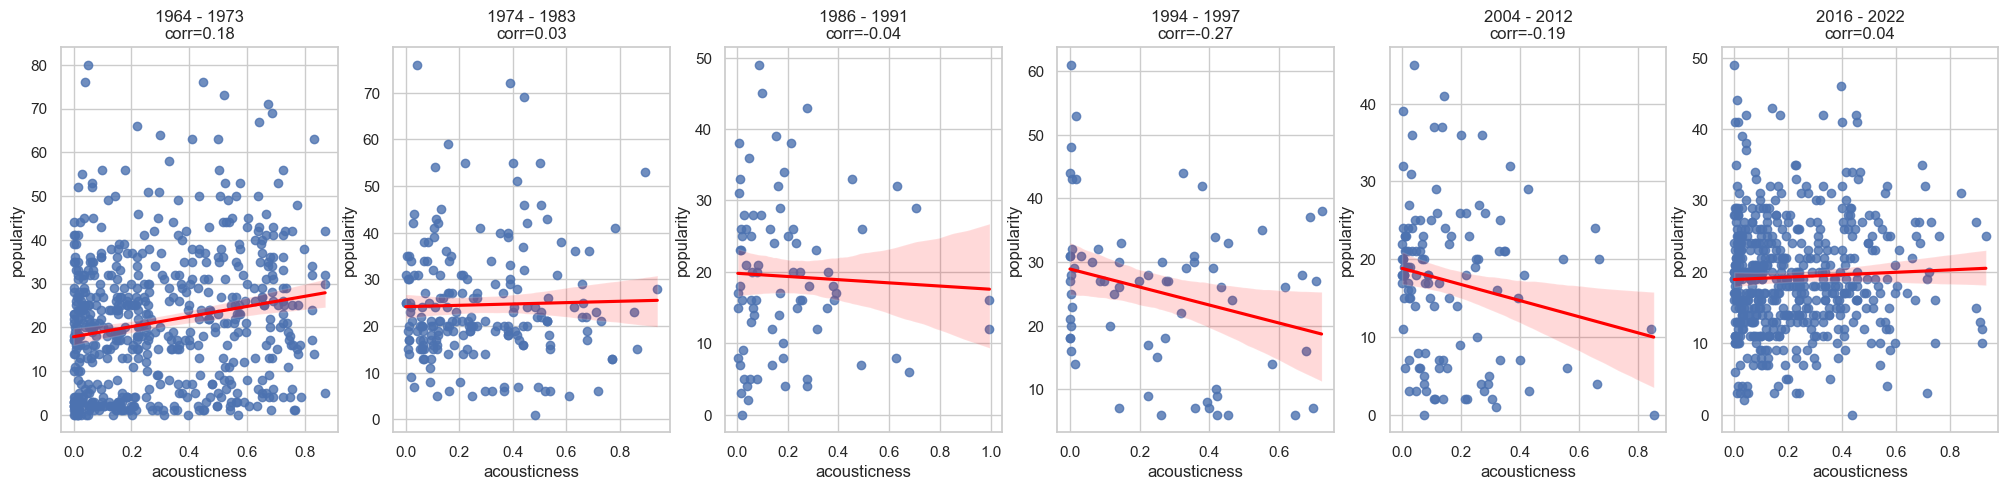

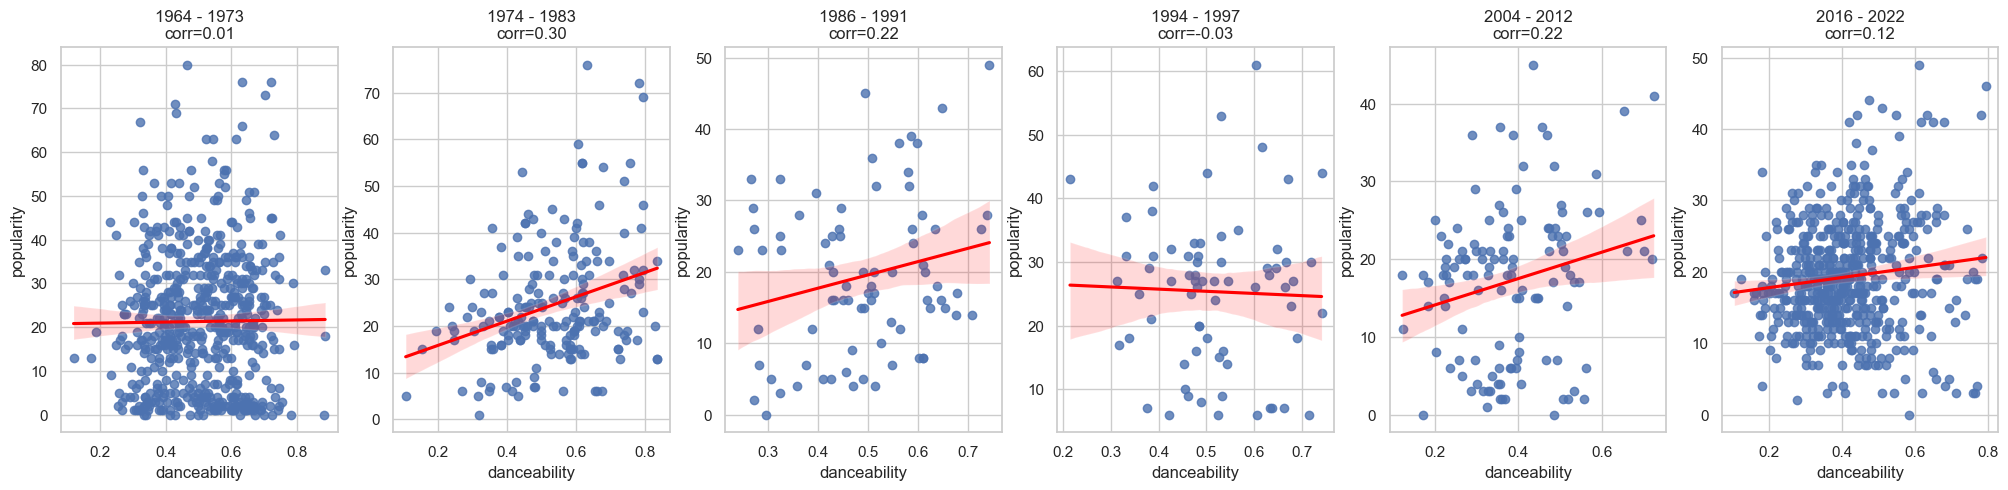

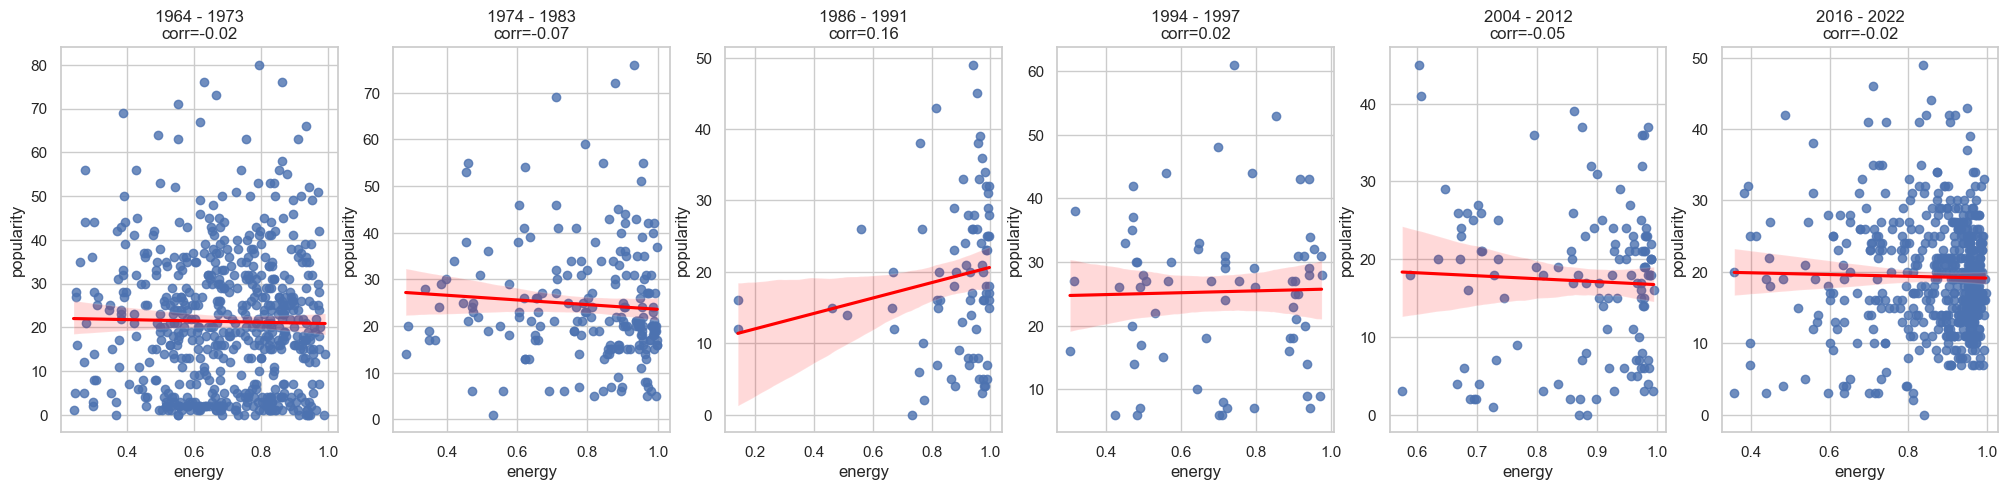

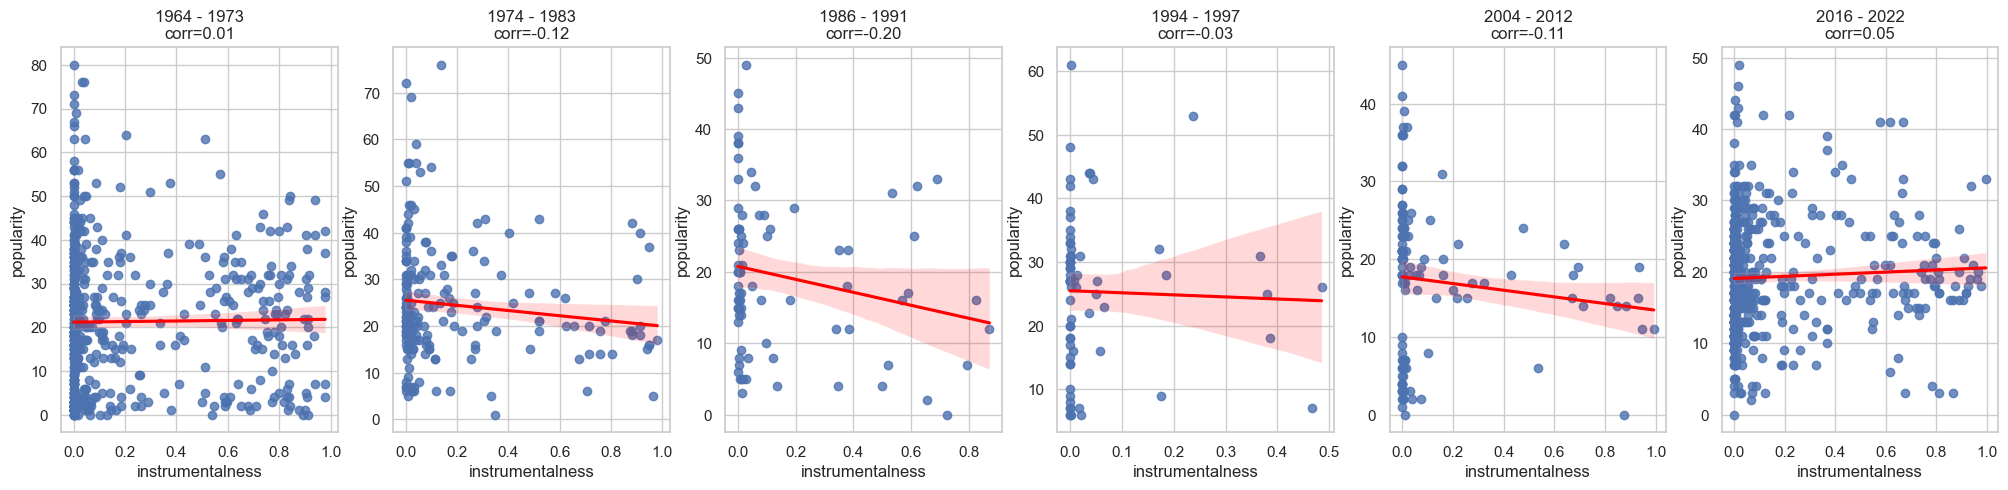

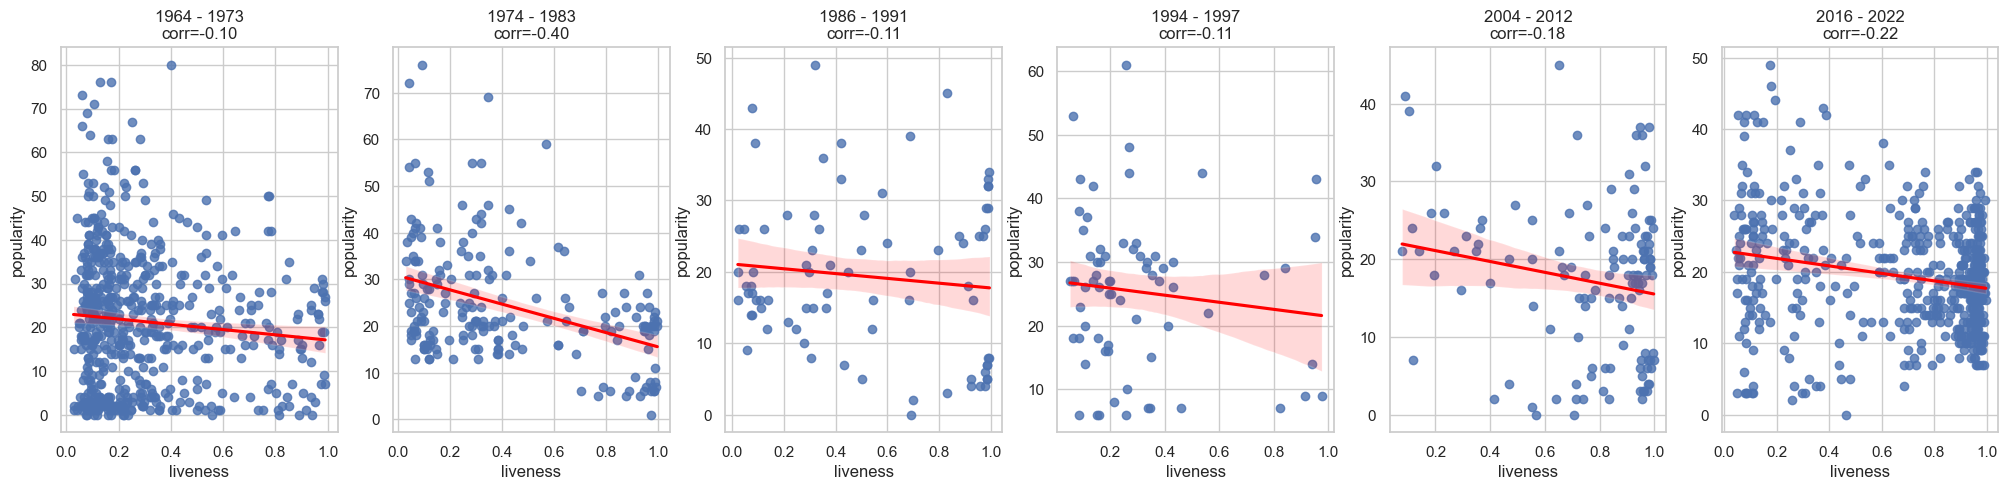

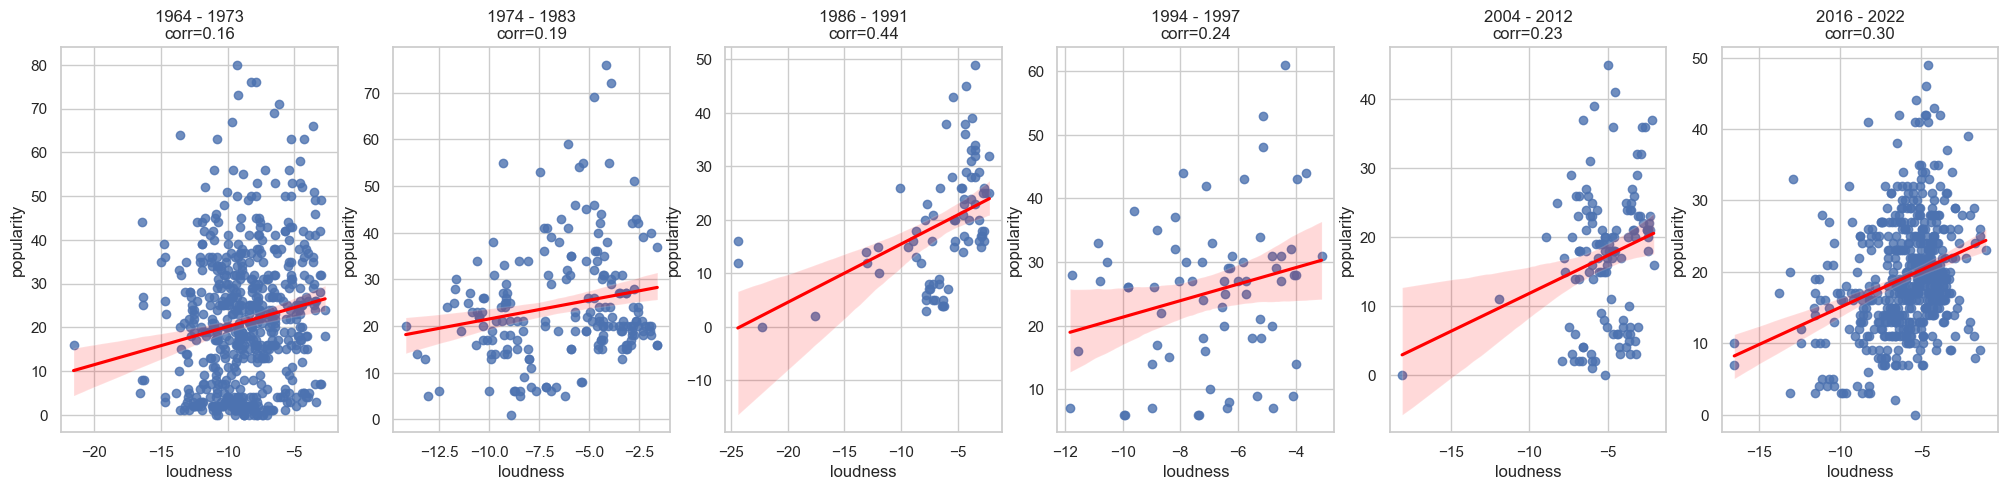

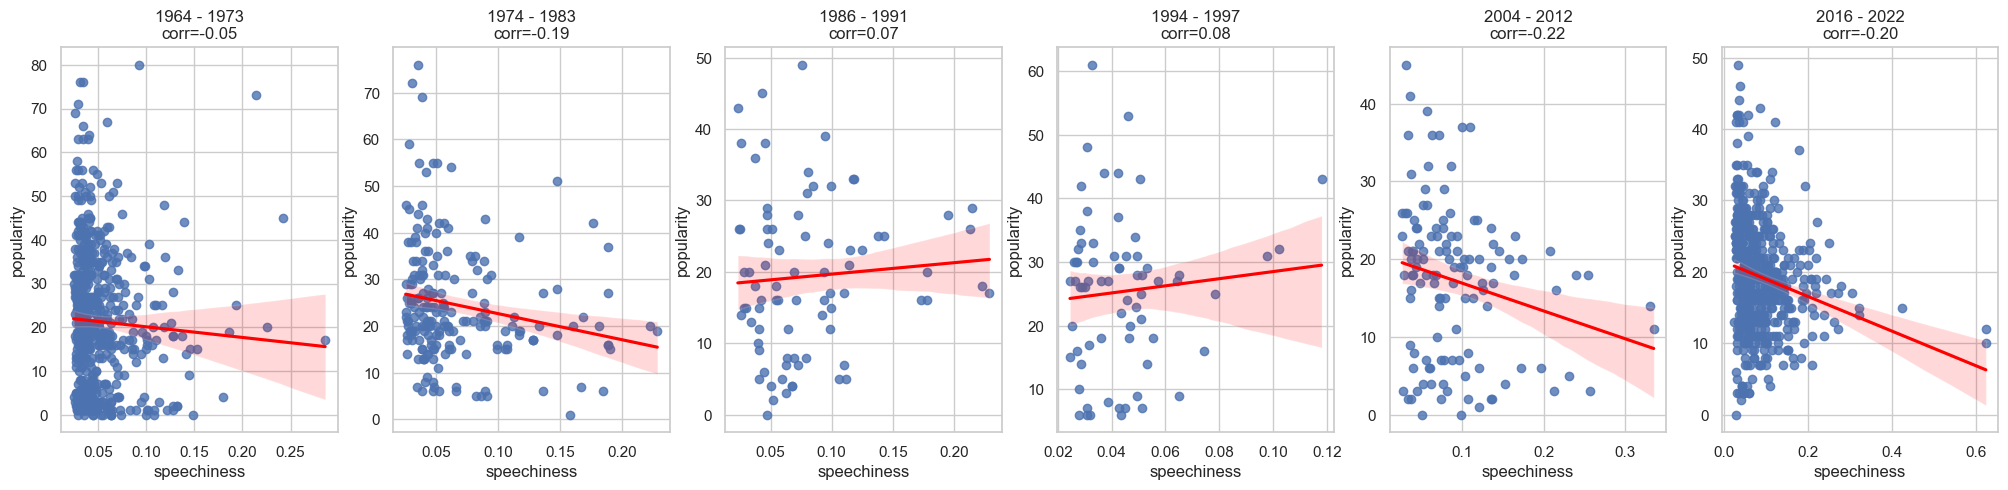

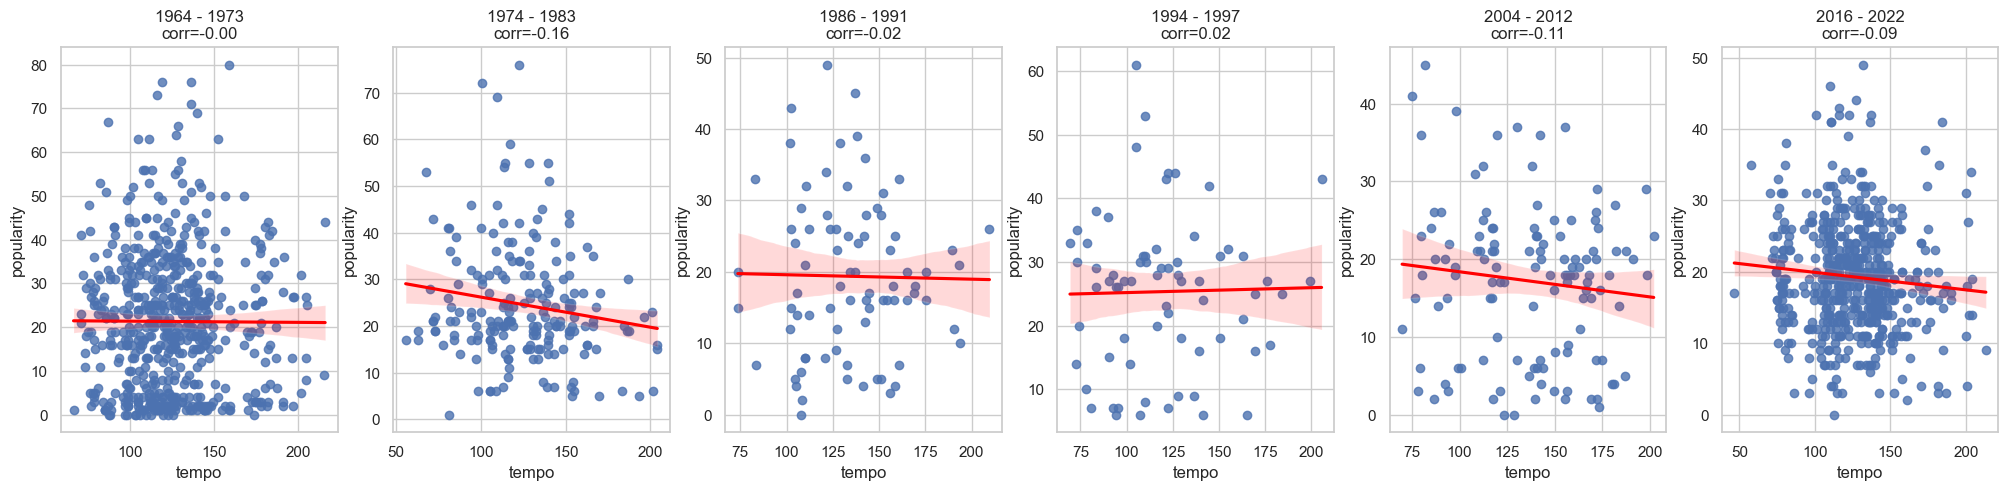

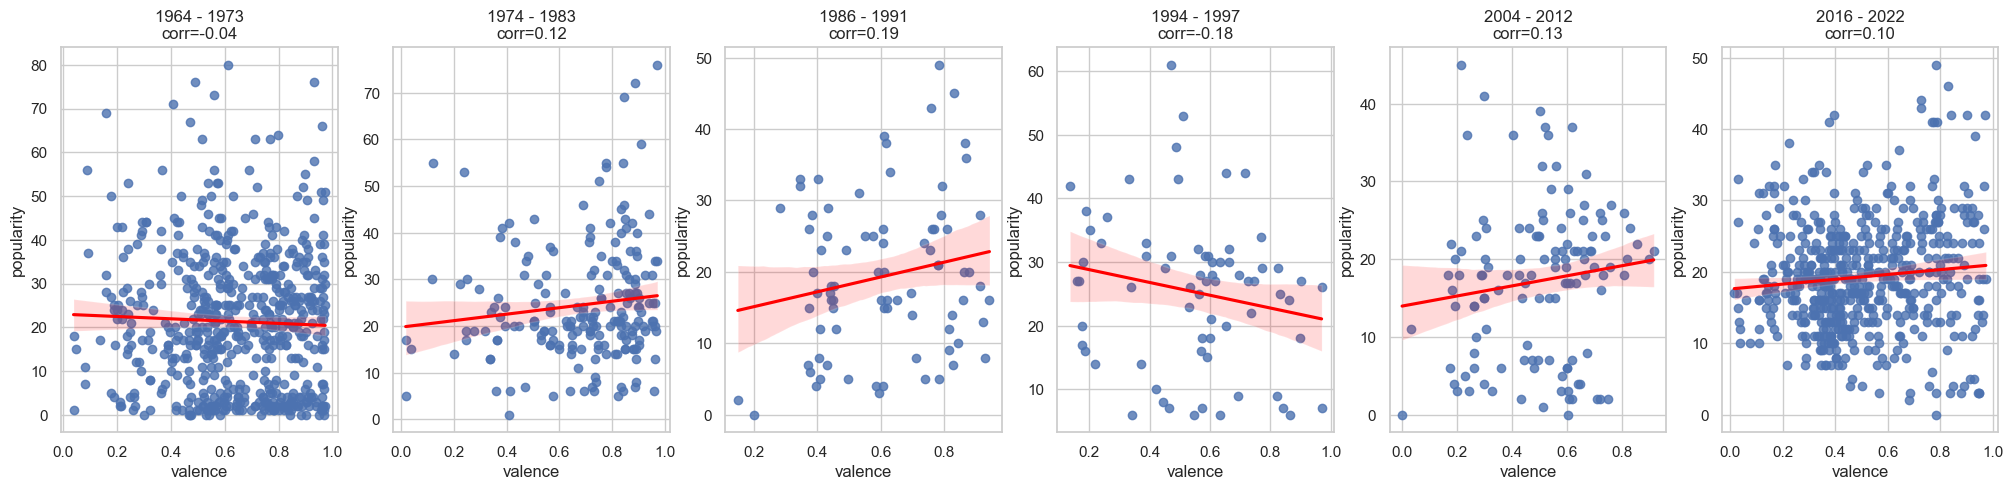

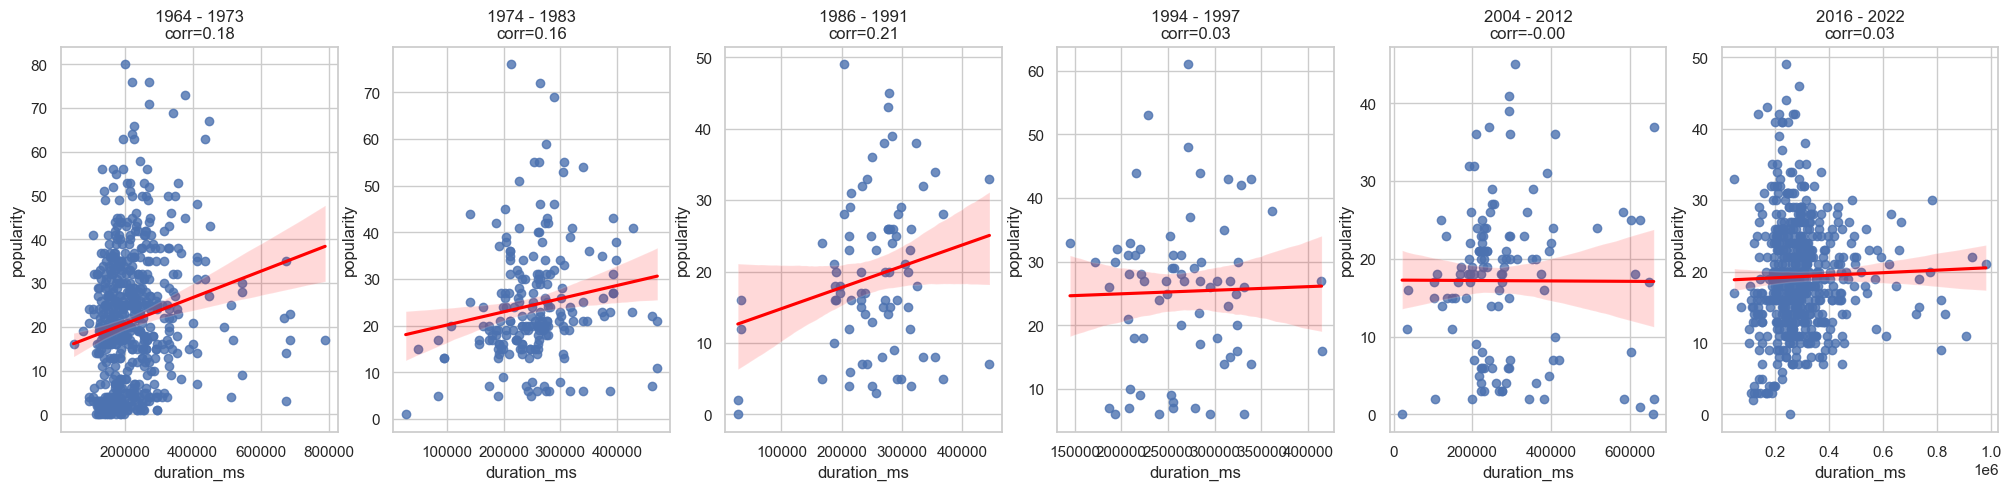

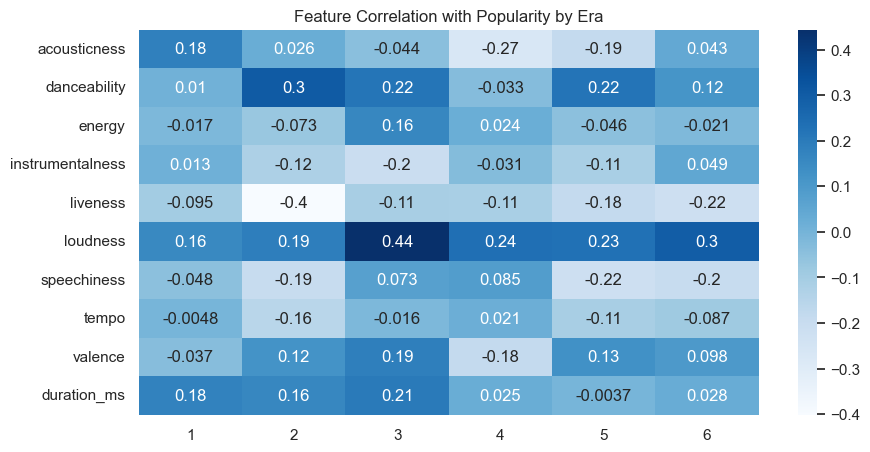

In [13]:
new_data['year_class'] = pd.cut(new_data.year, 6, labels=[1,2,3,4,5,6])
corr_d = {}

for v in vars:
    temp_d = []
    f, ax = plt.subplots(1, 6, figsize=(25, 5))
    for i, a in enumerate(range(1, 7)):
        sub = new_data[new_data.year_class == a]
        sns.regplot(x=v, y=y, data=sub, line_kws={'color':'red'}, ax=ax[i])
        corr = sub[v].corr(sub[y])
        temp_d.append(corr)
        ax[i].set_title(f"{sub.year.min()} - {sub.year.max()}\ncorr={corr:.2f}")
    corr_d[v] = temp_d

relationship = pd.DataFrame(corr_d, index=range(1, 7)).T
plt.figure(figsize=(10,5))
sns.heatmap(relationship, annot=True, cmap='Blues')
plt.title("Feature Correlation with Popularity by Era")
plt.show()

### Step 11: Principal Component Analysis (PCA)

Reducing dimensionality of audio features for easier clustering.

In [14]:
sc = StandardScaler()
features_scaled = sc.fit_transform(new_data.loc[:, 'acousticness':'duration_ms'])
pca = PCA(n_components=6)
pca_data = pca.fit_transform(features_scaled)
pca_df = pd.DataFrame(pca_data, columns=[f'PC{i+1}' for i in range(6)])

### Step 12: Combine PCA and Categorical Features

In [15]:
obj_cat_data = new_data.drop(columns=new_data.loc[:, 'acousticness':'duration_ms'].columns)
final_data = pd.concat([pca_df, obj_cat_data], axis=1)
final_data.drop(columns=['name'], inplace=True)
fd = pd.get_dummies(final_data)


### Step 13: KMeans Clustering on Final Dataset


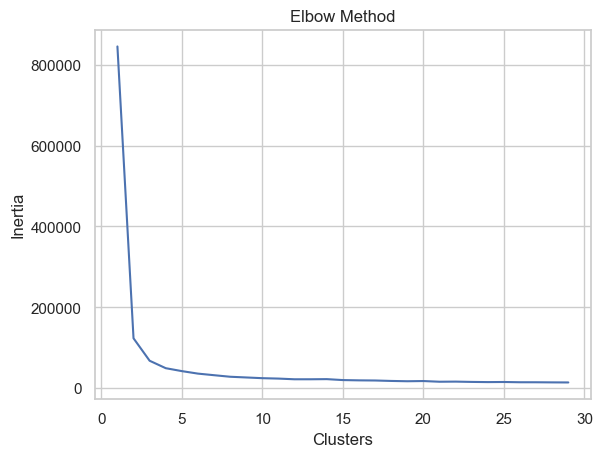

In [16]:
errors = []
for i in range(1, 30):
    kmm = KMeans(n_clusters=i)
    kmm.fit(fd)
    errors.append(kmm.inertia_)

plt.plot(range(1, 30), errors)
plt.title("Elbow Method")
plt.xlabel("Clusters")
plt.ylabel("Inertia")
plt.show()

kmm = KMeans(n_clusters=3)
fd['clus_label'] = kmm.fit_predict(fd)

### Step 14: Profiling Clusters

In [17]:
profile = fd.groupby('clus_label').mean()
profile.insert(0, 'Size', fd.groupby('clus_label').size())
profile


Size       PC1       PC2       PC3       PC4       PC5       PC6  \
clus_label                                                                     
0            717 -0.969389 -0.032378 -0.137497  0.108962  0.134355 -0.017718   
1            670  1.126557 -0.084123  0.089830 -0.071517 -0.187136 -0.017886   
2            223 -0.267900  0.356852  0.172196 -0.135471  0.130265  0.110705   

                   year       mon  album_12 X 5  ...  track_number_44  \
clus_label                                       ...                    
0           1969.470014  6.666667      0.016736  ...         0.000000   
1           2016.658209  8.511940      0.000000  ...         0.001493   
2           1988.520179  6.049327      0.000000  ...         0.000000   

            track_number_45  track_number_46  track_number_47  year_class_1  \
clus_label                                                                    
0                  0.000000         0.000000         0.000000      0.824268   
1                  0.001493         0.001493         0.001493      0.000000   
2                  0.000000         0.000000         0.000000      0.000000   

            year_class_2  year_class_3  year_class_4  year_class_5  \
clus_label                                                           
0               0.175732      0.000000      0.000000      0.000000   
1               0.000000      0.000000      0.000000      0.185075   
2               0.331839      0.358744      0.309417      0.000000   

            year_class_6  
clus_label                
0               0.000000  
1               0.814925  
2               0.000000  

[3 rows x 152 columns]

### Step 15: Cluster Visualization (PCA & Audio Features)

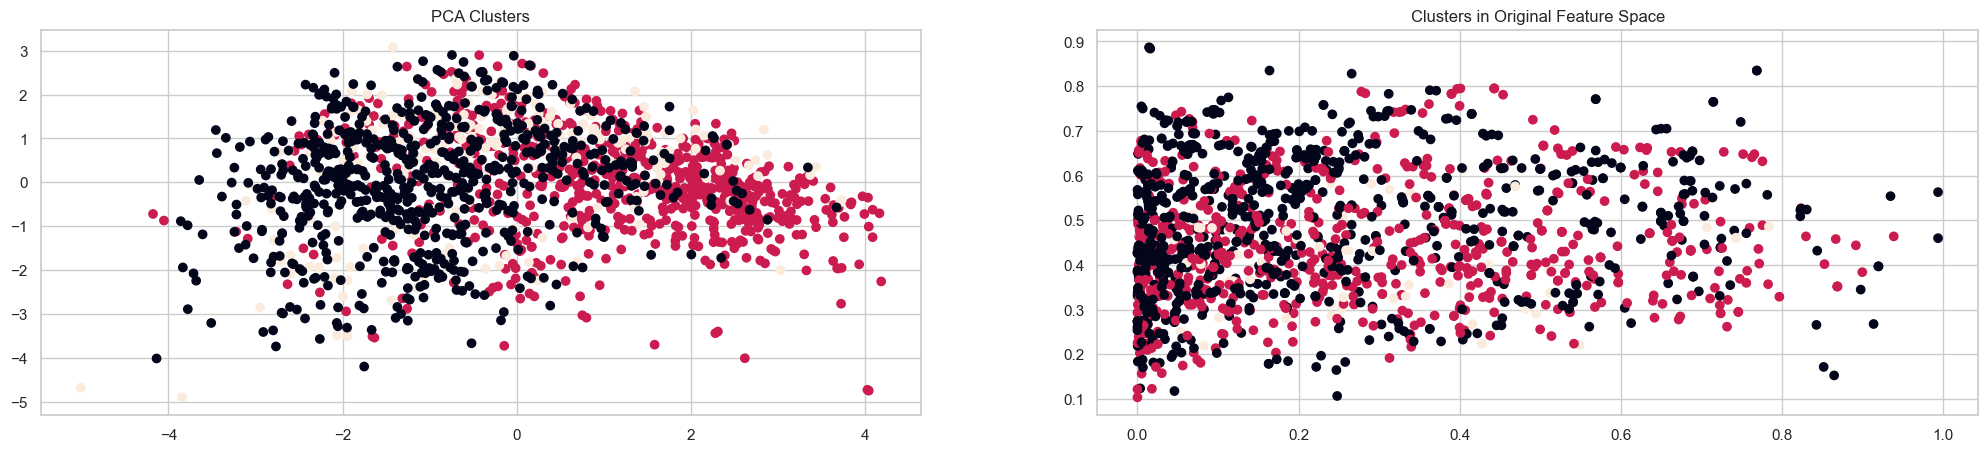

In [20]:
f, ax = plt.subplots(1, 2, figsize=(25, 5))
ax[0].scatter(fd.PC1, fd.PC2, c=fd.clus_label)
ax[0].set_title("PCA Clusters")

kmm = KMeans(n_clusters=3)
new_data_dummies = pd.get_dummies(new_data.drop(columns='name'))
new_data_dummies['cluster'] = kmm.fit_predict(new_data_dummies)
ax[1].scatter(new_data_dummies['acousticness'], new_data_dummies['danceability'], c=new_data_dummies['cluster'])
ax[1].set_title("Clusters in Original Feature Space")
plt.show()

## Conclusion

This analysis of The Rolling Stones' Spotify track data revealed several interesting insights:

- **Popularity Trends**: Some albums and years clearly stood out in terms of popularity, with certain audio features like danceability and energy showing positive correlation to track popularity.
- **Temporal Evolution**: Over time, musical features such as acousticness, valence, and tempo have evolved, reflecting stylistic changes in the band’s music.
- **Feature Relationships**: Features like loudness, energy, and valence showed consistent correlations with popularity across different eras.
- **Clustering**: Using PCA for dimensionality reduction and KMeans clustering, we grouped tracks into three distinct musical profiles based on their audio features, helping understand different "eras" or styles of The Rolling Stones' music.
- **Data Quality**: We addressed missing values, outliers, and cleaned categorical features, making the dataset analysis-ready.

This project demonstrates the power of combining **EDA, feature engineering, PCA**, and **unsupervised learning** for music data analysis, and is applicable to broader music catalog analytics or recommendation system foundations.
